In [1]:
from DistantSpeech.beamformer.utils import load_audio
from scipy.signal import convolve as conv
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from DistantSpeech.adaptivefilter.BaseFilter import BaseFilter, awgn
from DistantSpeech.adaptivefilter import FastFreqLms, SubbandLMS
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.transform.transform import Transform
from DistantSpeech.transform.subband import Subband
from DistantSpeech.beamformer.utils import pt

(336567,)


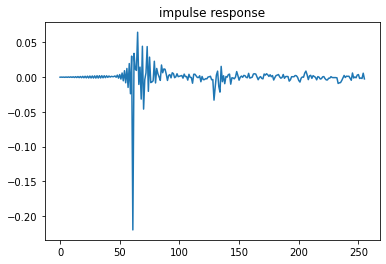

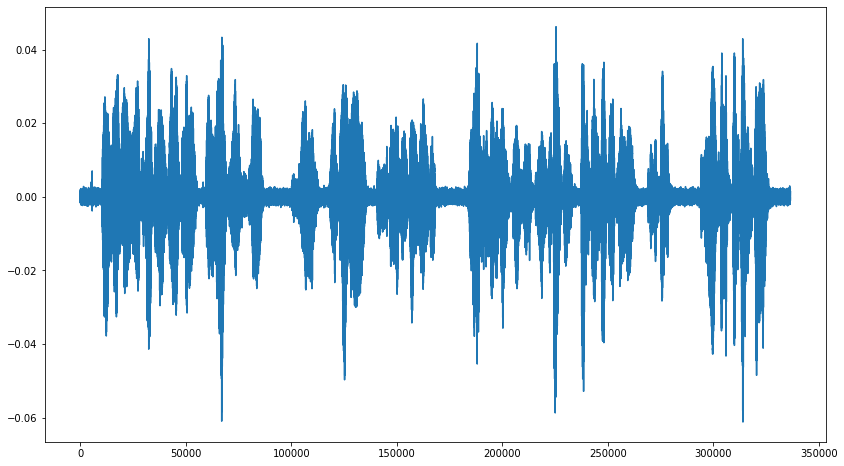

In [2]:
# load source single and rir
src = load_audio('/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav')
# src = np.random.rand(len(src))-0.5# * np.sqrt(npower)
print(src.shape)
rir = load_audio('/home/wangwei/work/DistantSpeech/DistantSpeech/adaptivefilter/rir.wav')
rir = rir[200:]

filter_len = 256

rir = rir[:filter_len, np.newaxis]
plt.figure()
plt.plot(rir)
plt.title('impulse response')
plt.show()

# src = awgn(src, 30)

SNR = 20
data_clean = conv(src, rir[:, 0])
data = data_clean[:len(src)]
data = awgn(data, SNR)
pt(data)

(336567,)
(336567,)
Loading analysis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/h-M512-m2-r1.pickle'
Loading synthesis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/g-M512-m2-r1.pickle'
self.h:(1024,)
self.g:(1024,)
Loading analysis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/h-M512-m2-r1.pickle'
Loading synthesis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/g-M512-m2-r1.pickle'
self.h:(1024,)
self.g:(1024,)
Loading analysis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/h-M512-m2-r1.pickle'
Loading synthesis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/g-M512-m2-r1.pickle'
self.h:(1024,)
self.g:(1024,)
Loading analysis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/h-M512-m2-r1.pickle'
Loading synthesis p

100%|██████████| 336311/336311 [00:09<00:00, 34831.58it/s]


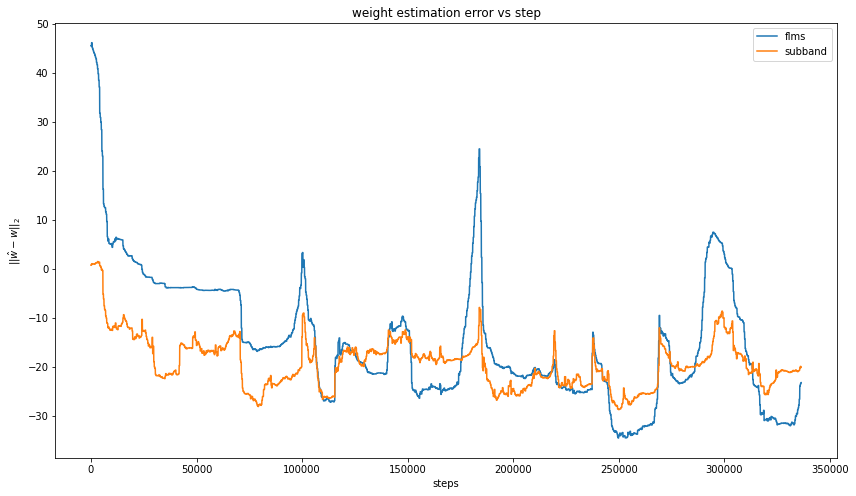

In [3]:




print(src.shape)
print(data.shape)
# audiowrite('src.wav', src)
# audiowrite('data.wav', data)

# array_data = audioread("/home/wangwei/work/DistantSpeech/example/mix.wav")
# src = array_data[:, 0]
# data = array_data[:, 1]

w = np.zeros((filter_len, 1))

transform_x = Transform(n_fft=512, hop_length=256)
transform_d = Transform(n_fft=512, hop_length=256)

StftLMS = SubbandLMS(filter_len=2, num_bands=512, mu=1e-1) # use stft subband

subband_lms = SubbandLMS(filter_len=2, num_bands=512, mu=1e-1) # use nyq subband

flms = FastFreqLms(filter_len=filter_len, mu=0.1)

valid_len = len(src)-flms.filter_len  # discard last frame

est_err_flms = np.zeros(valid_len)
est_err_stftlms = np.zeros(valid_len)

output_flms = np.zeros(data.shape)
output_stftlms = np.zeros(data.shape)
output_subbandlms = np.zeros(data.shape)

for n in tqdm(range((valid_len))):
    if np.mod(n, flms.filter_len) == 0:
        input_vector = src[n: n +  flms.filter_len]
        d_vector = data[n : n + flms.filter_len]

        err, w_flms = flms.update(input_vector, d_vector)
        output_flms[n : n + flms.filter_len] = err[:, 0]

        stft_err_fd, W_stftlms = StftLMS.update(transform_x.analysis(input_vector), transform_d.analysis(d_vector))
        w_stftlms = np.flip(np.fft.irfft(W_stftlms[0, :]))
        stft_err_td = transform_d.synthesis(stft_err_fd)
        output_stftlms[n : n + flms.filter_len] = stft_err_td

        subband_err_td, W_subbandlms = subband_lms.update(input_vector, d_vector)
        output_subbandlms[n : n + flms.filter_len] = subband_err_td

    est_err_flms[n] = np.sum(np.abs(rir - w_flms[:len(rir)])**2)
    est_err_stftlms[n] = np.sum(np.abs(np.abs(rir[1:, 0] - w_stftlms[:len(rir[:, 0])-1]))**2)
    

plt.figure(figsize=(14,8))
plt.plot(10 * np.log(est_err_flms / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.plot(10 * np.log(est_err_stftlms / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.legend(['flms', 'subband'], loc='upper right')
plt.xlabel("steps")
plt.ylabel("$\||\hat{w}-w\||_2$")
plt.title('weight estimation error vs step')
plt.show()

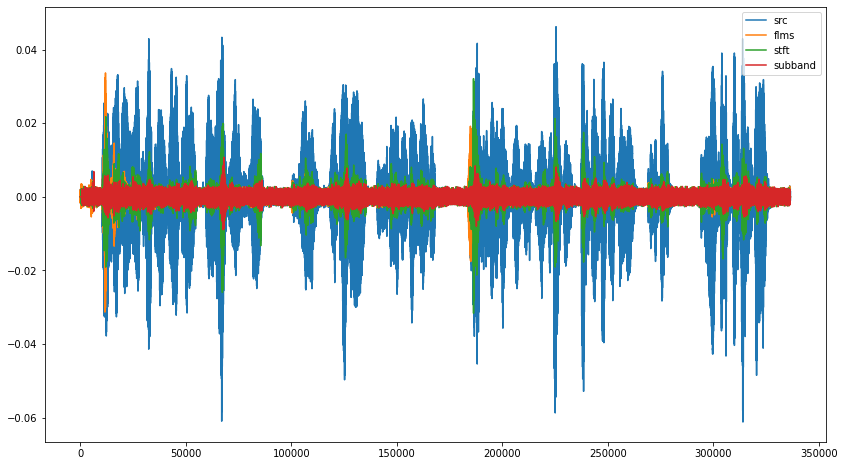

In [4]:
plt.figure(figsize=(14,8))
plt.plot(data)
plt.plot(output_flms)
plt.plot(output_stftlms)
plt.plot(output_subbandlms)

# plt.ylim([-0.05,0.05])
plt.legend(['src','flms', 'stft', 'subband'], loc='upper right')
plt.show()
audiowrite('flms.wav', output_flms)
audiowrite('subbandlms.wav', output_subbandlms)

(512,)


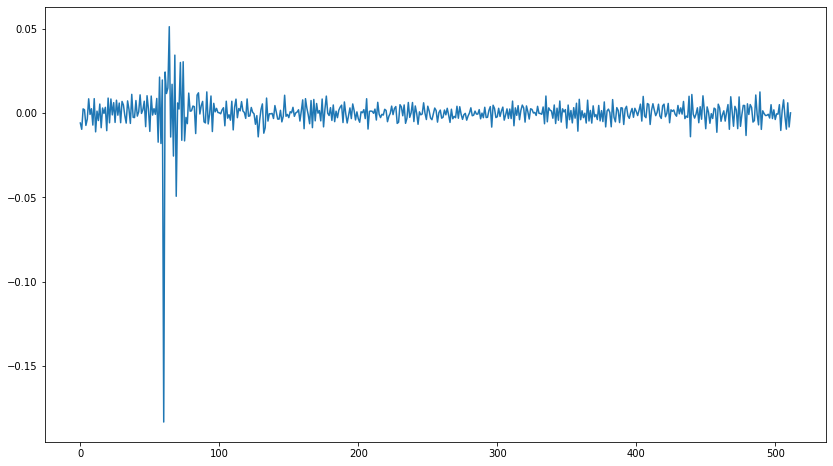

(50, 1)
0.0013265907860350817
0.0037048376363264866


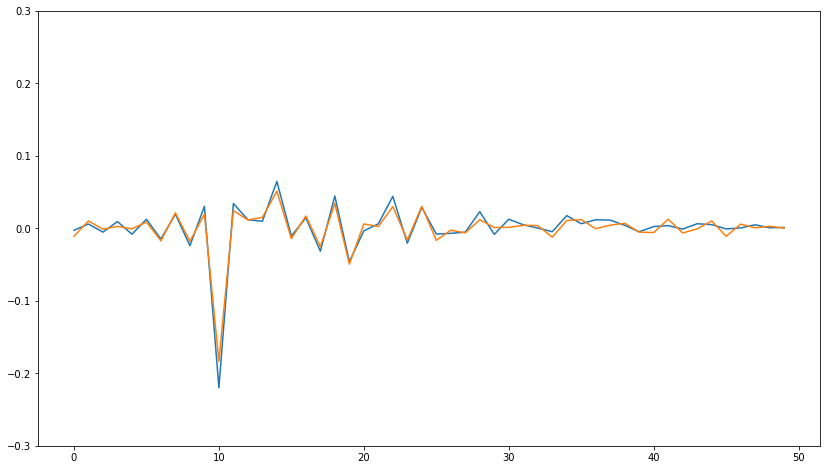

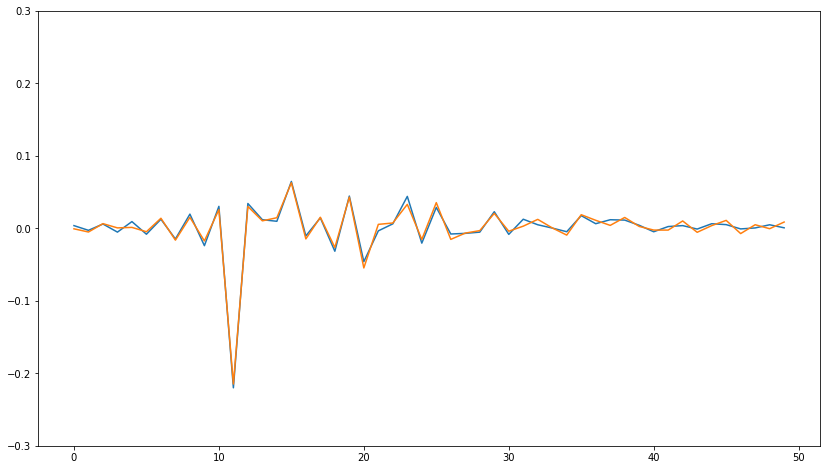

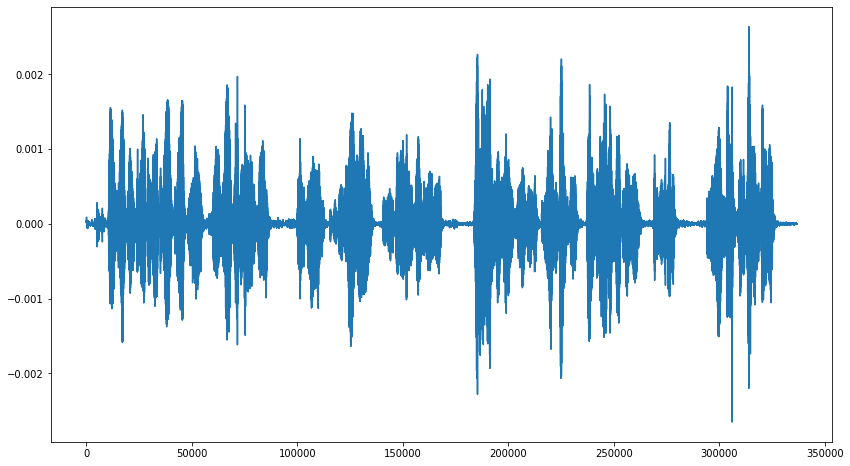

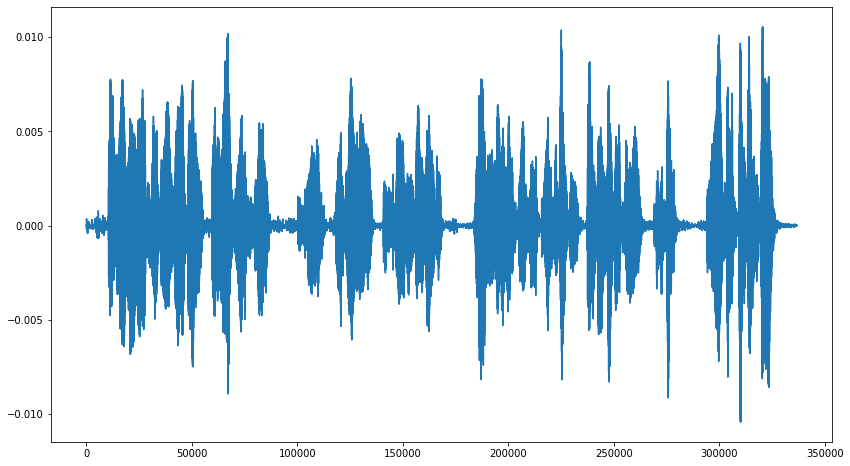

In [5]:
print(w_stftlms.shape)
pt(w_stftlms)
print(rir[50:100].shape)

err_flms = np.sum(np.abs(np.abs(rir[50:100, 0] - w_flms[50:100,0])**2))
err_subbandlms = np.sum(np.abs(np.abs(rir[1+50:1+100, 0] - w_stftlms[50:100]))**2)
print(err_flms)
print(err_subbandlms)

plt.figure(figsize=(14,8))
plt.plot(rir[1+50:1+100, 0])
plt.plot(w_stftlms[50:100])
plt.ylim([-0.3,0.3])
plt.show()

plt.figure(figsize=(14,8))
plt.plot(rir[50:100, 0])
plt.plot(w_flms[50:100,0])
plt.ylim([-0.3,0.3])
plt.show()

data = conv(src, rir[50:100, 0])

data1 = conv(src, w_flms[50:100,0])
data1 = data1[:len(data)]
pt(data1-data)

data1 = conv(src, w_stftlms[50:100])
data = conv(src, rir[1+50:1+100, 0])
data = data[:len(data1)]
pt(data1-data)

# audiowrite('data.wav', output)
